## Installs

In [ ]:
!apt-get install default-jre
!java -version

In [ ]:
!pip install h2o -qq

In [ ]:
!pip install autots

## Import Dependencies

In [5]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

In [6]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.17" 2025-10-21; OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04); OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5crxz1li
  JVM stdout: /tmp/tmp5crxz1li/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5crxz1li/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_2ou4gm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [7]:
from google.colab import auth, files
auth.authenticate_user()
print("Authenticated")

Authenticated


In [16]:
from google.cloud import bigquery
client = bigquery.Client(project="btcproject-480223")

query = """SELECT * FROM  `btcproject-480223.BTCData.bitcoin_history`"""
data = client.query(query).to_dataframe()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4096 non-null   dbdate 
 1   Close   4096 non-null   float64
 2   High    4096 non-null   float64
 3   Low     4096 non-null   float64
 4   Open    4096 non-null   float64
 5   Volume  4096 non-null   Int64  
dtypes: Int64(1), dbdate(1), float64(4)
memory usage: 196.1 KB


,Date,Close,High,Low,Open,Volume
0,2015-01-15,209.843994,229.067001,176.897003,176.897003,81773504
1,2015-01-18,210.339005,218.695007,194.505997,200.050003,30085100
2,2015-01-17,199.259995,211.731003,194.875000,207.834000,23469700
3,2015-01-16,208.097000,221.591003,199.770996,209.070007,38421000
4,2015-08-25,221.608994,226.320999,199.567001,210.067993,61089200


In [17]:
import io, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use("seaborn-v0_8")
pd.set_option('display.max_columns', 50)

data['Date'] = pd.to_datetime(data['Date'])
data = data[data['Date'] >= '2018-01-01'].reset_index(drop=True)

data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894 entries, 0 to 2893
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2894 non-null   datetime64[ns]
 1   Close   2894 non-null   float64       
 2   High    2894 non-null   float64       
 3   Low     2894 non-null   float64       
 4   Open    2894 non-null   float64       
 5   Volume  2894 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), float64(4)
memory usage: 138.6 KB


,Date,Close,High,Low,Open,Volume
0,2018-12-16,3252.839111,3305.753174,3233.819824,3236.274658,3744248994
1,2018-12-15,3236.761719,3275.377930,3191.303467,3243.997559,3551763561
2,2018-12-17,3545.864746,3597.917969,3253.123047,3253.123047,5409247918


##Feature Engineering

In [19]:
# Time-based features
def TimeFeatures(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.sort_values("Date").reset_index(drop=True)

    # Basic calendar features
    data["day_of_week"] = data["Date"].dt.dayofweek       # 0 = Monday, 6 = Sunday
    data["month"] = data["Date"].dt.month
    data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)

    # Cyclical encoding for day of week and month
    data["sin_dow"] = np.sin(2 * np.pi * data["day_of_week"] / 7)
    data["cos_dow"] = np.cos(2 * np.pi * data["day_of_week"] / 7)
    data["sin_month"] = np.sin(2 * np.pi * data["month"] / 12)
    data["cos_month"] = np.cos(2 * np.pi * data["month"] / 12)

    return data

In [20]:
# Return-based features (Uses only historical information – safe for forecasting.)
def ReturnsFeatures(data: pd.DataFrame, n_lags_return: int = 3) -> pd.DataFrame:
    data = data.copy()
    data = data.sort_values("Date").reset_index(drop=True)

    # Simple and log returns
    data["return_pct"] = data["Close"].pct_change()
    data["return_log"] = np.log(data["Close"] / data["Close"].shift(1))

    # Lagged log returns
    for lag in range(1, n_lags_return + 1):
        data[f"return_log_lag_{lag}"] = data["return_log"].shift(lag)

    return data

In [21]:
# Moving average features (Compute simple moving averages of the Close price for given windows)
def MVGAverageFeatures(
    data: pd.DataFrame,
    windows=(7, 30, 50, 200),
) -> tuple[pd.DataFrame, list[str]]:
    data = data.copy()
    data = data.sort_values("Date").reset_index(drop=True)

    sma_cols = []
    for w in windows:
        col = f"close_sma_{w}"
        data[col] = data["Close"].rolling(window=w, min_periods=w).mean()
        sma_cols.append(col)

    return data, sma_cols

In [28]:
# Volatility features (rolling std + ATR)
def _true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    range1 = high - low
    range2 = (high - prev_close).abs()
    range3 = (low - prev_close).abs()
    tr = pd.concat([range1, range2, range3], axis=1).max(axis=1)
    return tr

# Compute volatility features: Rolling std of log returns over given windows, ATR over atr_window
def VolatilityFeatures(
    data: pd.DataFrame,
    windows_std=(7, 30),
    atr_window: int = 14,
) -> tuple[pd.DataFrame, list[str]]:
    data = data.copy()
    data = data.sort_values("Date").reset_index(drop=True)

    vol_cols = []

    # Ensure we have log returns
    if "return_log" not in data.columns:
        data["return_log"] = np.log(data["Close"] / data["Close"].shift(1))

    # Rolling std (volatility of log returns) for 7 & 30 days
    for w in windows_std:
        col = f"return_log_std_{w}"
        data[col] = data["return_log"].rolling(window=w, min_periods=w).std()
        vol_cols.append(col)

    # Volatility 7/14/30d (named features)
    data["volatility_7d"] = data["return_log"].rolling(7).std()
    data["volatility_14d"] = data["return_log"].rolling(14).std()
    data["volatility_30d"] = data["return_log"].rolling(30).std()
    vol_cols += ["volatility_7d", "volatility_14d", "volatility_30d"]

    # ATR
    data["true_range"] = _true_range(data["High"], data["Low"], data["Close"])
    atr_col = f"atr_{atr_window}"
    data[atr_col] = data["true_range"].rolling(window=atr_window, min_periods=atr_window).mean()
    vol_cols.append(atr_col)

    return data, vol_cols

In [23]:
# Volume, candle, and lagged-close features (Add: Raw Volume, Dollar volume, Volume change (%), High–low range (candle size), Lagged Close prices)
def VolumeCandleLaggedCloseFeatures(
    data: pd.DataFrame,
    n_lags_close: int = 7,
) -> tuple[pd.DataFrame, list[str]]:
    data = data.copy()
    data = data.sort_values("Date").reset_index(drop=True)

    new_cols = []

    # Dollar volume
    data["dollar_volume"] = data["Close"] * data["Volume"]
    new_cols.append("dollar_volume")

    # Volume change (%)
    data["volume_change_pct"] = data["Volume"].pct_change()
    new_cols.append("volume_change_pct")

    # High–Low range (candle body/length)
    data["range_hl"] = data["High"] - data["Low"]
    new_cols.append("range_hl")

    # Lagged close prices
    for lag in range(1, n_lags_close + 1):
        col = f"close_lag_{lag}"
        data[col] = data["Close"].shift(lag)
        new_cols.append(col)

    return data, new_cols

In [37]:
# Extra technical features (EMAs, momentum, rolling extremes, target)
def ExtraTechnicalFeatures(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    data = data.sort_values("Date").reset_index(drop=True)

    # EMAs
    data["close_ema_7"] = data["Close"].ewm(span=7, adjust=False).mean()
    data["close_ema_30"] = data["Close"].ewm(span=30, adjust=False).mean()

    # Close over SMA ratios (if SMAs exist)
    if "close_sma_7" in data.columns:
        data["close_over_sma_7"] = data["Close"] / data["close_sma_7"]
    else:
        data["close_over_sma_7"] = np.nan

    if "close_sma_30" in data.columns:
        data["close_over_sma_30"] = data["Close"] / data["close_sma_30"]
    else:
        data["close_over_sma_30"] = np.nan

    # Momentum features
    data["momentum_7d"]  = data["Close"].pct_change(7)
    data["momentum_14d"] = data["Close"].pct_change(14)
    data["momentum_30d"] = data["Close"].pct_change(30)

    # Rolling max/min
    data["rolling_max_7d"]  = data["Close"].rolling(7).max()
    data["rolling_min_7d"]  = data["Close"].rolling(7).min()
    data["rolling_max_14d"] = data["Close"].rolling(14).max()
    data["rolling_min_14d"] = data["Close"].rolling(14).min()
    data["rolling_max_30d"] = data["Close"].rolling(30).max()
    data["rolling_min_30d"] = data["Close"].rolling(30).min()

    # Target: next-day close
    data["target_next_close"] = data["Close"].shift(-1)

    return data

In [38]:
# Full feature engineering stack
def FeatureEngineeringStack(
    data: pd.DataFrame,
    n_lags_return: int = 3,
    n_lags_close: int = 7,
    atr_window: int = 14,
) -> pd.DataFrame:
    df = data.copy()
    df = df.sort_values("Date").reset_index(drop=True)

    # Time features
    df = TimeFeatures(df)
    # Return-based features
    df = ReturnsFeatures(df, n_lags_return=n_lags_return)
    # Moving averages of Close (7 & 30)
    df, _ = MVGAverageFeatures(df, windows=(7, 30))
    # Volatility features (rolling std & ATR + volatility_7/14/30)
    df, _ = VolatilityFeatures(df, windows_std=(7, 30), atr_window=atr_window)
    # Volume, candle, and lagged close features
    df, _ = VolumeCandleLaggedCloseFeatures(df, n_lags_close=n_lags_close)
    # EMAs, momentum, rolling extremes, target
    df = ExtraTechnicalFeatures(df)
    # Drop rows with NaNs caused by rolling/shift operations
    df = df.dropna().reset_index(drop=True)

    return df


In [39]:
df = FeatureEngineeringStack(data)
df.head()

,Date,Close,High,Low,Open,Volume,day_of_week,month,is_weekend,sin_dow,cos_dow,sin_month,cos_month,return_pct,return_log,return_log_lag_1,return_log_lag_2,return_log_lag_3,close_sma_7,close_sma_30,return_log_std_7,return_log_std_30,volatility_7d,volatility_14d,volatility_30d,...,atr_14,dollar_volume,volume_change_pct,range_hl,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,close_lag_7,close_ema_7,close_ema_30,close_over_sma_7,close_over_sma_30,momentum_7d,momentum_14d,momentum_30d,rolling_max_7d,rolling_min_7d,rolling_max_14d,rolling_min_14d,rolling_max_30d,rolling_min_30d,target_next_close
0,2018-01-31,10221.099609,10381.599609,9777.419922,10108.200195,8041160192,2,1,0,0.974928,-0.222521,0.500000,0.866025,0.011359,0.011295,-0.111325,-0.042454,0.029761,11040.228655,13066.503353,0.048859,0.066341,0.048859,0.058188,0.066341,...,1045.669922,82189499297373.0,-0.06908,604.179688,10106.299805,11296.400391,11786.299805,11440.700195,11171.400391,11259.400391,11359.400391,10897.381528,12294.297236,0.925805,0.782237,-0.100208,-0.086472,-0.251596,11786.299805,10106.299805,12899.200195,10106.299805,17527.0,10106.299805,9170.540039
1,2018-02-01,9170.540039,10288.799805,8812.280273,10237.299805,9959400448,3,2,0,0.433884,-0.900969,0.866025,0.500000,-0.102783,-0.108458,0.011295,-0.111325,-0.042454,10741.820033,12872.784701,0.059980,0.065809,0.059980,0.063328,0.065809,...,1067.935617,91333080573441.0,0.238553,1476.519531,10221.099609,10106.299805,11296.400391,11786.299805,11440.700195,11171.400391,11259.400391,10465.671156,12092.764513,0.853723,0.712398,-0.185521,-0.200817,-0.387900,11786.299805,9170.540039,12899.200195,9170.540039,17527.0,9170.540039,8830.750000
2,2018-02-02,8830.750000,9142.280273,7796.490234,9142.280273,12726899712,4,2,0,-0.433884,-0.900969,0.866025,0.500000,-0.037052,-0.037756,-0.108458,0.011295,-0.111325,10407.441406,12660.443034,0.059256,0.065655,0.059256,0.063051,0.065655,...,1107.460589,112388069631744.0,0.277878,1345.790039,9170.540039,10221.099609,10106.299805,11296.400391,11786.299805,11440.700195,11171.400391,10056.940867,11882.311964,0.848503,0.697507,-0.209522,-0.239214,-0.419068,11786.299805,8830.750000,12899.200195,8830.750000,17527.0,8830.750000,9174.910156
3,2018-02-03,9174.910156,9430.750000,8251.629883,8852.120117,7263790080,5,2,1,-0.974928,-0.222521,0.866025,0.500000,0.038973,0.038233,-0.037756,-0.108458,0.011295,10083.757115,12446.300033,0.061780,0.065979,0.061780,0.054811,0.065979,...,1084.854911,66644621377860.0,-0.429257,1179.120117,8830.750000,9170.540039,10221.099609,10106.299805,11296.400391,11786.299805,11440.700195,9836.433189,11707.640880,0.909870,0.737160,-0.198046,-0.288723,-0.411835,11786.299805,8830.750000,11786.299805,8830.750000,17527.0,8830.750000,8277.009766
4,2018-02-04,8277.009766,9334.870117,8031.220215,9175.700195,7073549824,6,2,1,-0.781831,0.623490,0.866025,0.500000,-0.097865,-0.102991,0.038233,-0.037756,-0.108458,9582.429967,12141.217025,0.060185,0.063094,0.060185,0.054453,0.063094,...,1062.901332,58547840970883.0,-0.02619,1303.649902,9174.910156,8830.750000,9170.540039,10221.099609,10106.299805,11296.400391,11786.299805,9446.577333,11486.309840,0.863769,0.681728,-0.297743,-0.286471,-0.525115,11296.400391,8277.009766,11786.299805,8277.009766,17527.0,8277.009766,6955.270020


In [41]:
# Forecasting Features
keep_cols = [
    'Close', 'Volume',
    'day_of_week', 'month', 'is_weekend',
    'sin_dow', 'cos_dow', 'sin_month', 'cos_month',
    'return_log_lag_1', 'return_log_lag_2', 'return_log_lag_3',
    'range_hl',
    'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_4',
    'close_lag_5', 'close_lag_6', 'close_lag_7',
    'target_next_close',
    'volatility_7d', 'momentum_7d', 'rolling_max_7d', 'rolling_min_7d',
    'volatility_14d', 'momentum_14d', 'rolling_max_14d', 'rolling_min_14d',
    'volatility_30d', 'momentum_30d', 'rolling_max_30d', 'rolling_min_30d'
]

In [42]:
# Keep only Forecasting Features
df = df[keep_cols].copy()

In [43]:
df.columns

Index(['Close', 'Volume', 'day_of_week', 'month', 'is_weekend', 'sin_dow',
       'cos_dow', 'sin_month', 'cos_month', 'return_log_lag_1',
       'return_log_lag_2', 'return_log_lag_3', 'range_hl', 'close_lag_1',
       'close_lag_2', 'close_lag_3', 'close_lag_4', 'close_lag_5',
       'close_lag_6', 'close_lag_7', 'target_next_close', 'volatility_7d',
       'momentum_7d', 'rolling_max_7d', 'rolling_min_7d', 'volatility_14d',
       'momentum_14d', 'rolling_max_14d', 'rolling_min_14d', 'volatility_30d',
       'momentum_30d', 'rolling_max_30d', 'rolling_min_30d'],
      dtype='object')

## H2o AutoML

In [49]:
## Split df into Train/Test
df_processed = df.copy()
df_processed.reset_index(drop=True,inplace=True)
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

In [ ]:
## Download Test Data
df_test.to_csv("model_test_data.csv")

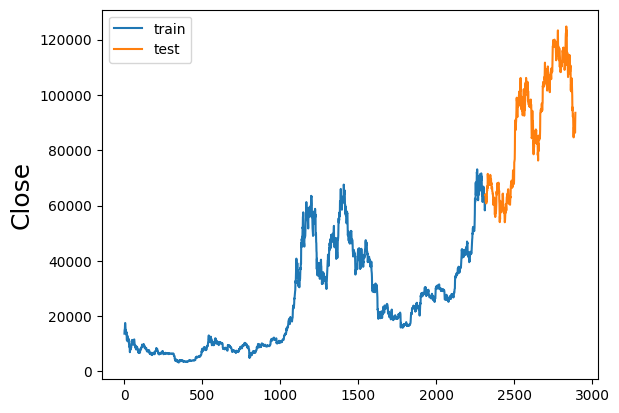

In [ ]:
# Plot of Close
plt.plot(df_train.index,df_train['Close'])
plt.plot(df_test.index,df_test['Close'])
plt.ylabel('Close',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [50]:
# Convert Pandas into H2o frames

hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Look into H2o frames

hf_train.describe()

Rows:2316
Cols:33

,Close,Volume,day_of_week,month,is_weekend,sin_dow,cos_dow,sin_month,cos_month,return_log_lag_1,return_log_lag_2,return_log_lag_3,range_hl,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,close_lag_7,target_next_close,volatility_7d,momentum_7d,rolling_max_7d,rolling_min_7d,volatility_14d,momentum_14d,rolling_max_14d,rolling_min_14d,volatility_30d,momentum_30d,rolling_max_30d,rolling_min_30d
type,real,int,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,3236.76171875,2923670016.0,0.0,1.0,0.0,-0.9749279121818236,-0.9009688679024191,-1.0,-1.0,-0.4647301753397729,-0.4647301753397729,-0.4647301753397729,18.922607421875,3236.76171875,3236.76171875,3236.76171875,3236.76171875,3236.76171875,3236.76171875,3236.76171875,3236.76171875,0.00199830817608,-0.0860513600221396,3502.656005859375,3236.76171875,0.0053741563208056,-0.0407362756823578,3602.46044921875,3236.76171875,0.0089255033834729,-0.0308080966889644,3728.568359375,3236.76171875
mean,23647.841650770137,25685963756.68958,2.998704663212433,6.310880829015552,0.28540587219343694,0.00033757836030570037,-0.0002692097590063793,0.03828882320217611,0.007852561951413229,0.0006822620409603602,0.0006022296571152997,0.0005972997951914041,1123.3309537001437,23626.367094524157,23604.805075637214,23585.60506121645,23566.758985344804,23547.41599939113,23526.802302806947,23505.607729896987,23669.59205345459,0.03130747812408063,0.000622333638996401,24660.91016963766,22492.54532983021,0.03264028698869441,0.0006151955718545155,25320.34632739132,21740.35483320431,0.033832019149717285,0.0006252088124343373,26378.111832113045,20494.960505721087
maxs,73083.5,350967941479.0,6.0,12.0,1.0,0.9749279121818236,1.0,1.0,1.0,0.1718205618881232,0.1718205618881232,0.1718205618881232,12864.62109375,73083.5,73083.5,73083.5,73083.5,73083.5,73083.5,73083.5,73083.5,0.1902843930564495,0.0484334234664736,73083.5,69455.34375,0.147446553639663,0.03614570374977,73083.5,65446.97265625,0.1036492759233503,0.0263412243602133,73083.5,61912.7734375
sigma,17651.55810558144,18682647127.55751,1.9998915860453672,3.482394213954835,0.45170505796002414,0.7072254294326011,0.7072934121657447,0.7114778417848622,0.7019279802574652,0.03658034995955344,0.03664936883607166,0.03664822416633497,1319.4914283495414,17632.820741590887,17615.311318083783,17600.808470955853,17587.033628314286,17570.872875710644,17551.574764701993,17533.37922844555,17670.267915113385,0.01884889883911046,0.014070357419961578,18392.181348833703,16726.319657483047,0.01674191753130892,0.010075452831046479,18833.273992285336,16130.317570531079,0.014823339485620125,0.007106998946076126,19441.856838458916,15144.635799449794
zeros,0,0,331,0,1655,331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,13657.2001953125,10291200000.0,0.0,1.0,0.0,0.0,1.0,0.4999999999999999,0.8660254037844387,0.0889011732809524,-0.1235977944869118,0.0033968323339576,957.5,14156.400390625,12952.2001953125,14656.2001953125,14606.5,15838.5,16099.7998046875,14026.599609375,14982.099609375,0.0914753631312613,-0.0038126613792419,16099.7998046875,12952.2001953125,0.0779443477891573,-0.0240117574325928,17776.69921875,12952.2001953125,0.0854924335999425,0.0069870902256488,19497.400390625,11323.2001953125
1,14982.099609375,16846600192.0,1.0,1.0,0.0,0.7818314824680297,0.6234898018587336,0.4999999999999999,0.8660254037844387,-0.0358999768524143,0.0889011732809524,-0.1235977944869118,2281.0,13657.2001953125,14156.400390625,12952.2001953125,14656.2001953125,14606.5,15838.5,16099.7998046875,15201.0,0.0807655339189534,-0.0102786726163908,15838.5,12952.2001953125,0.0824023631649118,-0.012216602714639,16624.599609375,12952.2001953125,0.0868790051894971,0.0093334131172883,19497.400390625,11657.2001953125
2,15201.0,16871900160.0,2.0,1.0,0.0,0.9749279121818236,-0.2225209339563143,0.4999999999999999,0.866025403784

In [83]:
# AML(Run AutoML)

y = "target_next_close"
X = hf_train.columns
X.remove(y)

aml = H2OAutoML(seed = 10, verbosity="info", nfolds=0, sort_metric="RMSE", max_runtime_secs = 1000)
aml.train(x = X,
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |
22:36:25.669: Project: AutoML_11_20251211_223625
22:36:25.670: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:36:25.670: Setting stopping tolerance adaptively based on the training frame: 0.020892357824136742
22:36:25.670: Build control seed: 10
22:36:25.670: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
22:36:25.679: training frame: Frame key: AutoML_11_20251211_223625_training_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 2071  chunks: 1    size: 454303  checksum: 8413832746138776416
22:36:25.680: validation frame: Frame key: AutoML_11_20251211_223625_validation_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 220  chunks: 1    size: 50554  checksum: -4831857983691112288
22:36:25.681: leaderboard frame: Frame key: Key_Frame__upload_a1a8d1cb128aa63e7de6c260173645

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_11_20251211_223625_model_3


Status of Neuron Layers: predicting target_next_close, regression, gaussian distribution, Quadratic loss, 681 weights/biases, 17.0 KB, 2,961,530 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate             rate_rms                momentum    mean_weight             weight_rms           mean_bias             bias_rms
--  -------  -------  ----------------  ---------  ----  ----  --------------------  ----------------------  ----------  ----------------------  -------------------  --------------------  -----------------------
    1        32       Input             20.0
    2        20       RectifierDropout  30.0       0.0   0.0   0.03005184291760088   0.017705440521240234    0.0         -1.877698268799577e-05  0.17668133974075317  0.4054962037403563    0.18848633766174316
    3        1        Linear                       0.0   0.0   0.001032615230360534  0.00032303063198924065  0.0         0.009288663044571877    0.07129135727882385  -0.15024306747699154  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 5764374.583539965
RMSE: 2400.911198595226
MAE: 2056.269192352194
RMSLE: 0.30536120144742657
Mean Residual Deviance: 5764374.583539965

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 4776410.775525921
RMSE: 2185.500120230132
MAE: 1897.1089577948965
RMSLE: 0.349642909367692
Mean Residual Deviance: 4776410.775525921

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2025-12-11 22:50:45  0.000 sec                           0         0             0            nan              nan                  nan             nan            nan                nan                    nan               nan
    2025-12-11 22:50:45  1 min 26.068 sec  52563 obs/sec     10        1             20710        2400.91          5.76437e+06          2056.27         0.98188        2185.5             4.77641e+06            1897.11           0.984493
    2025-12-11 22:50:50  1 min 31.135 sec  117713 obs/sec    310       31            642010       7254.1           5.2622e+07           6413.83         0.834582       7215.22            5.20594e+07            6387.49           0.830986
    2025-12-11 22:50:55  1 min 36.307 sec  120962 obs/sec    620       62            1.28402e+06  5862.74          3.43718e+07          5221.83         0.891952       5973.6             3.56838e+07            5307.36           0.88415
    2025-12-11 22:51:00  1 min 41.315 sec  110067 obs/sec    830       83            1.71893e+06  10796.1          1.16556e+08          9669.87         0.633605       10834.9            1.17396e+08            9659.3            0.618868
    2025-12-11 22:51:05  1 min 46.367 sec  114264 obs/sec    1140      114           2.36094e+06  11322.3          1.28194e+08          10100.1         0.597018       11410.3            1.30194e+08            10129             0.577317
    2025-12-11 22:51:10  1 min 51.489 sec  114908 obs/sec    1430      143           2.96153e+06  3100.21          9.61129e+06          2215.45         0.969787       3011.75            9.07065e+06            1964.88           0.970552
    2025-12-11 22:51:10  1 min 51.503 sec  114890 obs/sec    1430      143           2.96153e+06  2400.91          5.76437e+06          2056.27         0.98188        2185.5             4.77641e+06            1897.11           0.984493

Var

In [84]:
## Check Leaderboard

lb = aml.leaderboard

lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
DeepLearning_grid_1_AutoML_11_20251211_223625_model_3,2737.67,7.49481e+06,2114.57,0.0307722,7.49481e+06
DeepLearning_grid_1_AutoML_11_20251211_223625_model_2,2895.6,8.38452e+06,2249.36,0.031948,8.38452e+06
DeepLearning_grid_1_AutoML_11_20251211_223625_model_1,4642.07,2.15488e+07,3696.32,0.0504102,2.15488e+07
DeepLearning_grid_1_AutoML_11_20251211_223625_model_4,18862,3.55774e+08,16997.7,0.209818,3.55774e+08
DeepLearning_1_AutoML_11_20251211_223625,20793.1,4.32352e+08,18912.6,0.237316,4.32352e+08
DeepLearning_grid_2_AutoML_11_20251211_223625_model_2,24113.9,5.81481e+08,21631,0.276053,5.81481e+08
XGBoost_grid_1_AutoML_11_20251211_223625_model_321,27612.6,7.62457e+08,21985.1,0.315096,7.62457e+08
XGBoost_grid_1_AutoML_11_20251211_223625_model_260,28153.8,7.92635e+08,22508.8,0.32301,7.92635e+08
XGBoost_grid_1_AutoML_11_20251211_223625_model_78,28332.7,8.02743e+08,22548,0.325584,8.02743e+08
XGBoost_grid_1_AutoML_11_20251211_223625_model_264,28365.7,8.04614e+08,22715.6,0.326441,8.04614e+08


In [85]:
## Top Model

leader_model = aml.leader

## Make Predictions

hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Close'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
0,63049.960938,62512.927720
1,60792.777344,61378.036859
2,60793.710938,60045.439900
3,61448.394531,60891.298286
4,62901.449219,61398.758318
...,...,...
568,90919.265625,89770.734941
569,90851.757812,90171.469540
570,90394.312500,89866.097058
571,86321.570312,89444.048433


In [86]:
## Metrics

perf = leader_model.model_performance(hf_test)

mae = perf.mae()
print("MAE:", mae)

rmse = perf.rmse()
print("RMSE:", rmse)

r2 = perf.r2()
print("R^2:", r2)

mse = perf.mse()
print("MSE:", mse)

MAE: 2114.569535863584
RMSE: 2737.6650536385782
R^2: 0.9815601747888366
MSE: 7494809.94591392


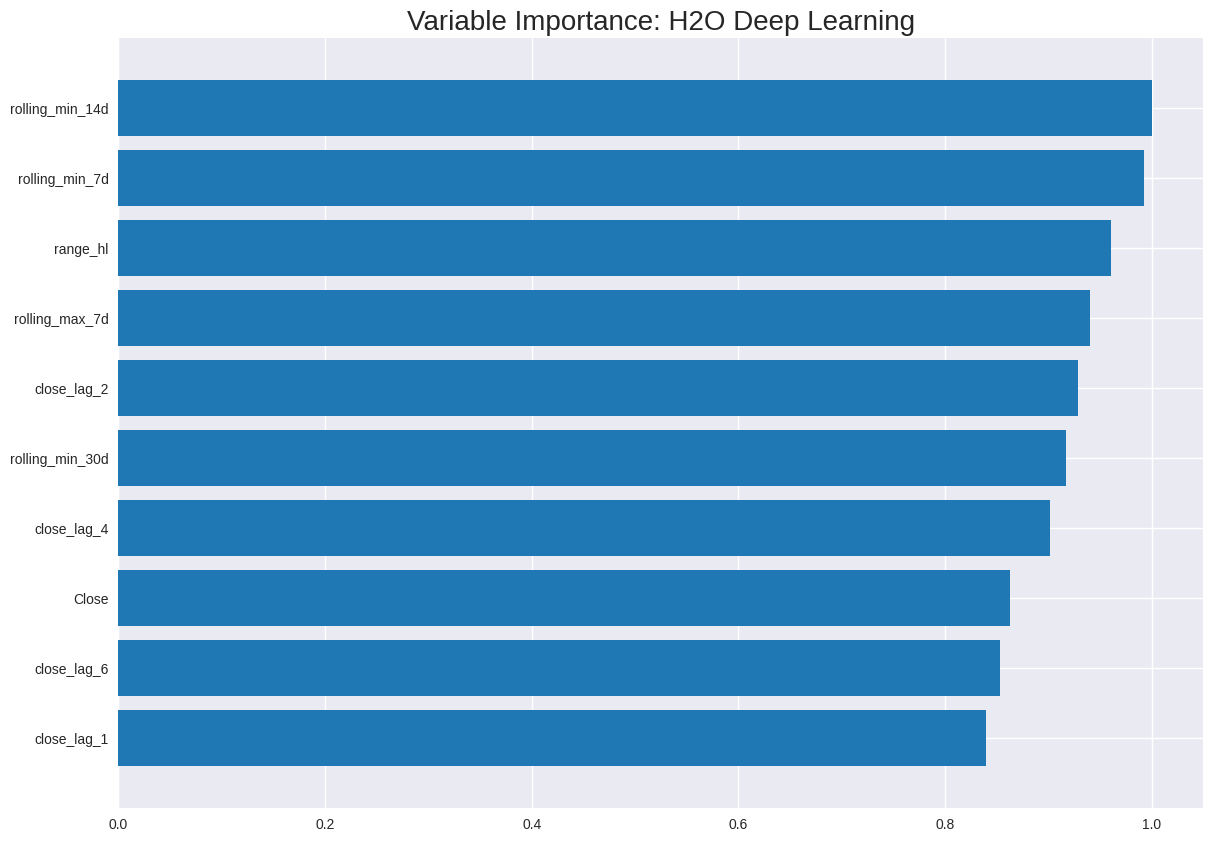

<Figure size 800x550 with 0 Axes>

In [87]:
# Top feature importance for top models

leader_model.varimp_plot()

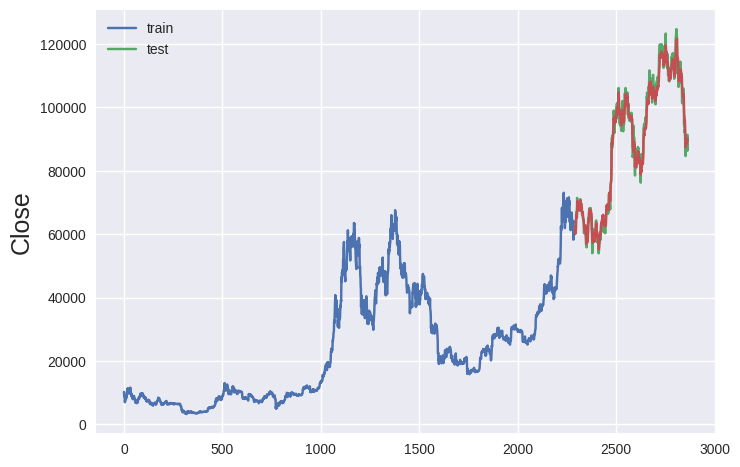

In [88]:
## Plot Train, Test, Predictions

plt.plot(df_train.index,df_train['Close'])
plt.plot(df_test.index,df_test['Close'])
plt.plot(df_test.index, df_results['predictions'])
plt.ylabel('Close',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [89]:
# Model leader

aml.leader.model_performance(hf_test)

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 7494809.94591392
RMSE: 2737.6650536385782
MAE: 2114.569535863584
RMSLE: 0.030772152469392754
Mean Residual Deviance: 7494809.94591392

In [90]:
# Save Model

model_path = h2o.save_model(model=leader_model, path="./saved_models", force=True)
print("Model saved to:", model_path)

Model saved to: /content/saved_models/DeepLearning_grid_1_AutoML_11_20251211_223625_model_3


In [97]:
import os

os.path.isfile("/content/saved_models/DeepLearning_grid_1_AutoML_11_20251211_223625_model_3")

True

In [98]:
!ls -l /content/saved_models

total 56
-rw-r--r-- 1 root root 56356 Dec 11 22:56 DeepLearning_grid_1_AutoML_11_20251211_223625_model_3


In [99]:
from google.colab import files
files.download("/content/saved_models/DeepLearning_grid_1_AutoML_11_20251211_223625_model_3")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['DeepLearning_grid_1_AutoML_11_20251211_223625_model_3',
 'DeepLearning_grid_1_AutoML_11_20251211_223625_model_2',
 'DeepLearning_grid_1_AutoML_11_20251211_223625_model_1',
 'DeepLearning_grid_1_AutoML_11_20251211_223625_model_4',
 'DeepLearning_1_AutoML_11_20251211_223625',
 'DeepLearning_grid_2_AutoML_11_20251211_223625_model_2',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_321',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_260',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_78',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_264',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_52',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_11',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_235',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_47',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_243',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_334',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_9',
 'XGBoost_grid_1_AutoML_11_20251211_223625_model_172',
 'XGBoost_g

## Change at least 2 feature values of the test dataset

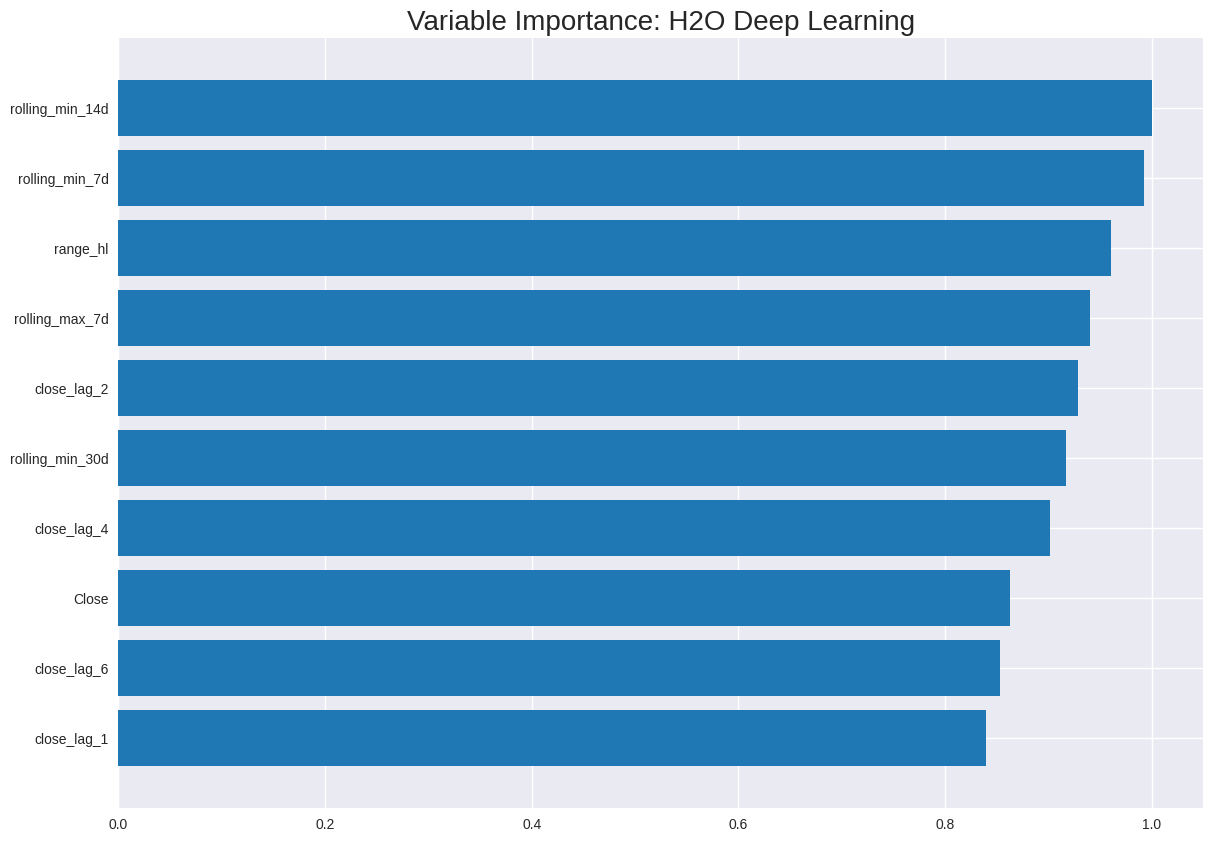

<Figure size 800x550 with 0 Axes>

In [93]:
leader_model.varimp_plot()

In [100]:
# Change some of the *most important* features

changed_df_test = df_test.copy()

# Make rolling minima artificially lower (simulate more bearish history)
changed_df_test["rolling_min_14d"] *= 0.7
changed_df_test["rolling_min_7d"]  *= 0.7

# Make the daily high–low range larger (simulate more volatile days)
changed_df_test["range_hl"] *= 1.5

# Slightly boost recent local maxima (simulate optimistic spikes)
changed_df_test["rolling_max_7d"] *= 1.1

# Randomly permute close_lag_2 values (swapping them between rows)
changed_df_test["close_lag_2"] = (
    changed_df_test["close_lag_2"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

# Convert changed_df_test to h2o frames
hf_changed_test = h2o.H2OFrame(changed_df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [101]:
changed_df_test.to_csv("changed_test_data.csv")

In [109]:
hf_changed_test["close_lag_2"] = hf_changed_test["close_lag_2"].asnumeric()
hf_changed_test_predict = leader_model.predict(hf_changed_test)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [110]:
## Make Predictions
hf_changed_test_predict = leader_model.predict(hf_changed_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Close'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_changed_test_predict,use_pandas=True)
df_results

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
0,63049.960938,55268.213671
1,60792.777344,54245.686479
2,60793.710938,52702.200470
3,61448.394531,53721.825148
4,62901.449219,54272.121543
...,...,...
568,90919.265625,79304.340129
569,90851.757812,79538.600308
570,90394.312500,79266.962383
571,86321.570312,79023.787079


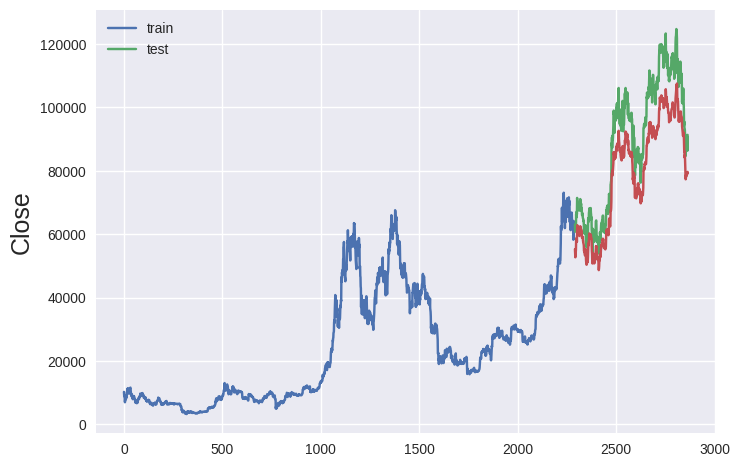

In [111]:
## Plot Train, Test, Predictions

plt.plot(df_train.index,df_train['Close'])
plt.plot(df_test.index,df_test['Close'])
plt.plot(df_test.index, df_results['predictions'])
plt.ylabel('Close',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [112]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = df_results['ground_truth'].values
y_pred = df_results['predictions'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)


print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 10695.06303002396
MSE: 126280668.52040334
RMSE: 11237.467175498372


## Additional Models (EXTRA)

In [78]:
# AML(Run AutoML) - DeepLearning
y = "target_next_close"
X = hf_train.columns
X.remove(y)

aml = H2OAutoML(max_models=20, seed = 10, verbosity="info", nfolds=0, max_runtime_secs = 600, sort_metric="RMSE", include_algos=["DeepLearning"])
aml.train(x = X,
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |
22:18:03.975: Project: AutoML_9_20251211_221803
22:18:03.975: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:18:03.975: Setting stopping tolerance adaptively based on the training frame: 0.020892357824136742
22:18:03.975: Build control seed: 10
22:18:03.976: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
22:18:03.998: training frame: Frame key: AutoML_9_20251211_221803_training_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 2071  chunks: 1    size: 454303  checksum: 8413832746138776416
22:18:04.1: validation frame: Frame key: AutoML_9_20251211_221803_validation_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 220  chunks: 1    size: 50554  checksum: -4831857983691112288
22:18:04.2: leaderboard frame: Frame key: Key_Frame__upload_a1a8d1cb128aa63e7de6c2601736453b.hex 

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_9_20251211_221803_model_1


Status of Neuron Layers: predicting target_next_close, regression, gaussian distribution, Quadratic loss, 1,701 weights/biases, 29.3 KB, 1,843,190 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight            weight_rms            mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  ---------------------  --------------------  -------------------  -----------------------
    1        32       Input             0.0
    2        50       RectifierDropout  30.0       0.0   0.0   0.041940384535701015   0.03420563042163849   0.0         0.010719168908372012   0.16188478469848633   0.16956915425697752  0.4919084310531616
    3        1        Linear                       0.0   0.0   0.0007283724096487276  0.000747268320992589  0.0         0.0010231191106140614  0.031168974936008453  -0.3366150694952171  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 1474084.40482522
RMSE: 1214.1187770664037
MAE: 781.7725472211723
RMSLE: 0.05598591711586712
Mean Residual Deviance: 1474084.40482522

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 1289273.978952919
RMSE: 1135.4620112328369
MAE: 770.6232737199076
RMSLE: 0.05697500480654706
Mean Residual Deviance: 1289273.978952919

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2025-12-11 22:18:04  0.000 sec                     0         0             0            nan              nan                  nan             nan            nan                nan                    nan               nan
    2025-12-11 22:18:05  1.242 sec   19894 obs/sec     10        1             20710        1871.77          3.50352e+06          1326.97         0.988987       1936.83            3.75129e+06            1352.39           0.987821
    2025-12-11 22:18:11  6.582 sec   29292 obs/sec     90        9             186390       1838.12          3.37867e+06          1209.65         0.989379       1902.68            3.62019e+06            1265.24           0.988247
    2025-12-11 22:18:16  11.692 sec  32520 obs/sec     180       18            372780       1744.7           3.04399e+06          1254.74         0.990431       1809.68            3.27495e+06            1324.35           0.989368
    2025-12-11 22:18:21  16.840 sec  36180 obs/sec     290       29            600590       1214.12          1.47408e+06          781.773         0.995366       1135.46            1.28927e+06            770.623           0.995814
    2025-12-11 22:18:26  22.073 sec  42706 obs/sec     450       45            931950       1312.49          1.72264e+06          902.863         0.994585       1276.04            1.62829e+06            920.533           0.994714
    2025-12-11 22:18:32  27.437 sec  46493 obs/sec     610       61            1.26331e+06  2290.8           5.24776e+06          1514.82         0.983504       2353.32            5.5381e+06             1595.19           0.98202
    2025-12-11 22:18:37  32.596 sec  46775 obs/sec     730       73            1.51183e+06  1492.88          2.22869e+06          1059.22         0.992994       1505.34            2.26605e+06            1116.3            0.992643
    2025-12-11 22:18:42  37.747 sec  49200 obs/sec     890       89     

In [79]:
## Check Leaderboard
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
DeepLearning_grid_1_AutoML_9_20251211_221803_model_1,3165.24,1.00187e+07,2411.65,0.0351388,1.00187e+07
DeepLearning_grid_1_AutoML_9_20251211_221803_model_3,3450.87,1.19085e+07,2739.18,0.0370992,1.19085e+07
DeepLearning_grid_1_AutoML_9_20251211_221803_model_2,4122.52,1.69951e+07,3307.42,0.043018,1.69951e+07
DeepLearning_grid_1_AutoML_9_20251211_221803_model_4,15009.6,2.25289e+08,13599.5,0.164782,2.25289e+08
DeepLearning_grid_1_AutoML_9_20251211_221803_model_6,15895.4,2.52665e+08,14519.9,0.178615,2.52665e+08
DeepLearning_grid_1_AutoML_9_20251211_221803_model_7,17185.9,2.95357e+08,15238.6,0.187247,2.95357e+08
DeepLearning_grid_1_AutoML_9_20251211_221803_model_5,20313,4.12616e+08,19739.5,0.260166,4.12616e+08
DeepLearning_1_AutoML_9_20251211_221803,21879,4.7869e+08,19819.7,0.249208,4.7869e+08
DeepLearning_grid_2_AutoML_9_20251211_221803_model_2,25667.5,6.58819e+08,22847.6,0.296291,6.58819e+08
DeepLearning_grid_2_AutoML_9_20251211_221803_model_4,27512.5,7.56939e+08,25181.7,0.32725,7.56939e+08


In [80]:
## Top Model
leader_model = aml.leader

## Make Predictions
hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Close'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
0,63049.960938,62135.703677
1,60792.777344,61350.982867
2,60793.710938,60610.000965
3,61448.394531,61450.706354
4,62901.449219,62001.869892
...,...,...
568,90919.265625,88363.451419
569,90851.757812,88704.385859
570,90394.312500,88894.184383
571,86321.570312,86609.126278


In [81]:
## Metrics
perf = leader_model.model_performance(hf_test)
mae = perf.mae()
print("MAE:", mae)
rmse = perf.rmse()
print("RMSE:", rmse)
r2 = perf.r2()
print("R^2:", r2)
mse = perf.mse()
print("MSE:", mse)

MAE: 2411.6483560127244
RMSE: 3165.2367365743867
R^2: 0.9753504740841192
MSE: 10018723.598560072


***GBM***

In [61]:
# AML(Run AutoML) - GBM
y = "target_next_close"
X = hf_train.columns
X.remove(y)

aml = H2OAutoML(seed = 10, verbosity="info", nfolds=0, max_runtime_secs = 300, sort_metric="RMSE", include_algos=["GBM"])
aml.train(x = X,
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |
22:00:39.88: Project: AutoML_4_20251211_220039
22:00:39.88: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:00:39.89: Setting stopping tolerance adaptively based on the training frame: 0.020892357824136742
22:00:39.89: Build control seed: 10
22:00:39.89: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
22:00:39.117: training frame: Frame key: AutoML_4_20251211_220039_training_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 2071  chunks: 1    size: 454303  checksum: 8413832746138776416
22:00:39.119: validation frame: Frame key: AutoML_4_20251211_220039_validation_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 220  chunks: 1    size: 50554  checksum: -4831857983691112288
22:00:39.120: leaderboard frame: Frame key: Key_Frame__upload_a1a8d1cb128aa63e7de6c2601736453b.hex  

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,75.0,75.0,49719.0,8.0,8.0,8.0,10.0,76.0,47.906666
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2025-12-11 22:02:03,1 min 17.243 sec,0.0,17835.7692884,15146.9923282,318114666.1096072,17553.5360567,15036.6453417,308126628.0944220
,2025-12-11 22:02:03,1 min 17.350 sec,5.0,10564.1741702,8954.2042138,111601775.8988090,10448.9546948,8914.8952229,109180654.2150158
,2025-12-11 22:02:03,1 min 17.453 sec,10.0,6278.8827263,5297.4181046,39424368.2907341,6251.7094121,5288.4866756,39083870.5729126
,2025-12-11 22:02:04,1 min 17.562 sec,15.0,3772.6911902,3145.7737174,14233198.8165784,3809.9793719,3163.3937969,14515942.8144961
,2025-12-11 22:02:04,1 min 17.670 sec,20.0,2330.9044393,1898.8284996,5433115.5052754,2411.0636474,1945.9068148,5813227.9118716
,2025-12-11 22:02:04,1 min 17.772 sec,25.0,1505.9612433,1178.4344960,2267919.2664458,1614.9973687,1244.5820518,2608216.5008220
,2025-12-11 22:02:04,1 min 17.868 sec,30.0,1068.4548565,787.4949319,1141595.7803507,1207.3330981,877.2913020,1457653.2097130
,2025-12-11 22:02:04,1 min 17.957 sec,35.0,837.2119665,575.2560232,700923.8768057,1014.1577837,703.5227861,1028516.0101541


In [62]:
## Check Leaderboard
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_4_20251211_220039_model_54,28966.7,8.39067e+08,23137.7,0.334863,8.39067e+08
GBM_grid_1_AutoML_4_20251211_220039_model_75,29028.4,8.42646e+08,23183.8,0.335756,8.42646e+08
GBM_grid_1_AutoML_4_20251211_220039_model_109,29038.2,8.43217e+08,23149.8,0.335868,8.43217e+08
GBM_grid_1_AutoML_4_20251211_220039_model_36,29055.9,8.44246e+08,23235.7,0.336175,8.44246e+08
GBM_grid_1_AutoML_4_20251211_220039_model_40,29071.8,8.45167e+08,23233.6,0.336462,8.45167e+08
GBM_grid_1_AutoML_4_20251211_220039_model_46,29081.6,8.45738e+08,23242.3,0.33653,8.45738e+08
GBM_grid_1_AutoML_4_20251211_220039_model_185,29088.5,8.46141e+08,23206.8,0.336518,8.46141e+08
GBM_grid_1_AutoML_4_20251211_220039_model_120,29088.8,8.46161e+08,23230.7,0.336684,8.46161e+08
GBM_grid_1_AutoML_4_20251211_220039_model_96,29100,8.4681e+08,23339.2,0.337022,8.4681e+08
GBM_grid_1_AutoML_4_20251211_220039_model_174,29112,8.47506e+08,23306.5,0.337162,8.47506e+08


In [63]:
## Top Model
leader_model = aml.leader

## Make Predictions
hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Close'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
0,63049.960938,61845.296490
1,60792.777344,60944.869538
2,60793.710938,61813.743996
3,61448.394531,62844.080146
4,62901.449219,63304.104567
...,...,...
568,90919.265625,68841.880157
569,90851.757812,70053.617930
570,90394.312500,69306.771322
571,86321.570312,67647.316421


In [64]:
## Metrics
perf = leader_model.model_performance(hf_test)
mae = perf.mae()
print("MAE:", mae)
rmse = perf.rmse()
print("RMSE:", rmse)
r2 = perf.r2()
print("R^2:", r2)
mse = perf.mse()
print("MSE:", mse)

MAE: 23137.741352316876
RMSE: 28966.66002965755
R^2: -1.064396053270161
MSE: 839067393.2737602


***XGBoost***

In [65]:
# AML(Run AutoML) - XGBoost
y = "target_next_close"
X = hf_train.columns
X.remove(y)

aml = H2OAutoML(seed = 10, verbosity="info", nfolds=0, max_runtime_secs = 300, sort_metric="RMSE", include_algos=["XGBoost"])
aml.train(x = X,
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |
22:06:27.745: Project: AutoML_5_20251211_220627
22:06:27.745: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:06:27.745: Setting stopping tolerance adaptively based on the training frame: 0.020892357824136742
22:06:27.745: Build control seed: 10
22:06:27.745: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
22:06:27.766: training frame: Frame key: AutoML_5_20251211_220627_training_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 2071  chunks: 1    size: 454303  checksum: 8413832746138776416
22:06:27.768: validation frame: Frame key: AutoML_5_20251211_220627_validation_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 220  chunks: 1    size: 50554  checksum: -4831857983691112288
22:06:27.768: leaderboard frame: Frame key: Key_Frame__upload_a1a8d1cb128aa63e7de6c2601736453b.

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_5_20251211_220627_model_78


Model Summary: 
    number_of_trees
--  -----------------
    40

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 807009.7283306097
RMSE: 898.3372019072848
MAE: 598.1590129975706
RMSLE: 0.04194931809608791
Mean Residual Deviance: 807009.7283306097

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 1103188.3532758784
RMSE: 1050.3277361261476
MAE: 687.120390181108
RMSLE: 0.04821407032552181
Mean Residual Deviance: 1103188.3532758784

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2025-12-11 22:08:28  1 min 57.187 sec  0                  29840.3          23923.5         8.90446e+08          29405.7            23594.1           8.64698e+08
    2025-12-11 22:08:28  1 min 57.280 sec  5                  5238.73          4094.56         2.74443e+07          5228.35            4060.45           2.73357e+07
    2025-12-11 22:08:28  1 min 57.315 sec  10                 1414.9           935.088         2.00194e+06          1400.83            923.974           1.96234e+06
    2025-12-11 22:08:28  1 min 57.351 sec  15                 1081.93          691.511         1.17058e+06          1049               683.08            1.10041e+06
    2025-12-11 22:08:28  1 min 57.388 sec  20                 1019.09          664.305         1.03855e+06          1036.07            673.948           1.07343e+06
    2025-12-11 22:08:28  1 min 57.425 sec  25                 981.895          646.182         964118               1050.74            685.923           1.10405e+06
    2025-12-11 22:08:28  1 min 57.463 sec  30                 944.434          625.063         891956               1049.95            691.455           1.10239e+06
    2025-12-11 22:08:28  1 min 57.504 sec  35                 925.45           614.796         856457               1083.11            703.429           1.17313e+06
    2025-12-11 22:08:29  1 min 57.545 sec  40                 898.337          598.159         807010               1050.33            687.12            1.10319e+06

Variable Importances: 
variable          relative_importance    scaled_importance       percentage
----------------  ---------------------  ----------------------  ----------------------
close_lag_1       379530412032.0         1.0                     0.48375724865881287
Close             228199366656.0         0.601267670314545       0.29086759389885847
close_lag_2       161730969600.0         0.426134413666865       0.20614561151431904
rolling_max_14d   5765635584.0           0.01519149823364846     0.007348997388514994
rolling_min_30d   3227371008.0           0.008503589977732496    0.004113673291350528
rolling_min_7d    2050012800.0           0.0054014454046627325   0.002612988367740432
rolling_max_7d    1442663680.0           0.0038011807071691587   0.0018388487205551129
close_lag_4       601853952.0            0.0015857858367072171   0.0007671353933275969
momentum_7d       241704896.0            0.0006368525112544096   0.00030808201864588886
close_lag_7       182371440.0            0.0004805186467761203   0.0002324543784936719
---               ---                    ---                     ---
close_lag_5       78230608.0             0.00020612474131165016  9.971433773743343e-05
rolling_min_14d   74028424.0             0.00019505267997801007  9.435814780969007e-05
return_log_lag_1  69171480.0             0.00018225543410251883  8.816738735455209e-05
day_of_week       60948196.0             0.0001605884378900871   7.76858208801252e-05
rolling_max_30d   52193296.0             0.00013752072125276573  6.652664574681349e-

In [66]:
## Check Leaderboard
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
XGBoost_grid_1_AutoML_5_20251211_220627_model_78,28332.7,8.02743e+08,22548,0.325584,8.02743e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_52,28441.5,8.0892e+08,22791.9,0.327312,8.0892e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_11,28467.1,8.10378e+08,22765.6,0.327549,8.10378e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_47,28671.5,8.22056e+08,22868.5,0.330534,8.22056e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_9,28702.9,8.23859e+08,22907.1,0.330903,8.23859e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_172,28713.9,8.24489e+08,22889,0.331046,8.24489e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_60,28720.6,8.24873e+08,22918.4,0.331245,8.24873e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_160,28734.7,8.25682e+08,22923.8,0.331536,8.25682e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_87,28746.9,8.26384e+08,23010.2,0.331643,8.26384e+08
XGBoost_grid_1_AutoML_5_20251211_220627_model_14,28766.9,8.27534e+08,23004.6,0.331904,8.27534e+08


In [67]:
## Top Model
leader_model = aml.leader

## Make Predictions
hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Close'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
0,63049.960938,61966.605469
1,60792.777344,63010.210938
2,60793.710938,62072.722656
3,61448.394531,62000.523438
4,62901.449219,62638.449219
...,...,...
568,90919.265625,69170.171875
569,90851.757812,69465.890625
570,90394.312500,70143.109375
571,86321.570312,69685.054688


In [68]:
## Metrics
perf = leader_model.model_performance(hf_test)
mae = perf.mae()
print("MAE:", mae)
rmse = perf.rmse()
print("RMSE:", rmse)
r2 = perf.r2()
print("R^2:", r2)
mse = perf.mse()
print("MSE:", mse)

MAE: 22548.00783295157
RMSE: 28332.71746645585
R^2: -0.9750251821880278
MSE: 802742879.0340126


***DRF***

In [69]:
# AML(Run AutoML) - DRF
y = "target_next_close"
X = hf_train.columns
X.remove(y)

aml = H2OAutoML(seed = 10, verbosity="info", nfolds=0, max_runtime_secs = 300, sort_metric="RMSE", include_algos=["DRF"])
aml.train(x = X,
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |
22:11:49.521: Project: AutoML_6_20251211_221149
22:11:49.521: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:11:49.521: Setting stopping tolerance adaptively based on the training frame: 0.020892357824136742
22:11:49.521: Build control seed: 10
22:11:49.521: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
22:11:49.596: training frame: Frame key: AutoML_6_20251211_221149_training_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 2071  chunks: 1    size: 454303  checksum: 8413832746138776416
22:11:49.598: validation frame: Frame key: AutoML_6_20251211_221149_validation_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 220  chunks: 1    size: 50554  checksum: -4831857983691112288
22:11:49.598: leaderboard frame: Frame key: Key_Frame__upload_a1a8d1cb128aa63e7de6c2601736453b.

,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,35.0,35.0,565483.0,19.0,20.0,19.971428,1254.0,1323.0,1282.5143
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2025-12-11 22:11:53,0.015 sec,0.0,nan,nan,nan,nan,nan,nan
,2025-12-11 22:11:53,0.740 sec,5.0,1458.0240512,841.5986195,2125834.1337520,1013.2650438,621.6605185,1026706.0489857
,2025-12-11 22:11:54,1.466 sec,10.0,1288.4114154,748.7317760,1660003.9753743,932.4563055,579.1786681,869474.7617528
,2025-12-11 22:11:55,2.253 sec,15.0,1226.4613305,711.5884381,1504207.3951736,890.4556769,557.2919713,792911.3124953
,2025-12-11 22:11:56,2.977 sec,20.0,1182.5720132,685.6154986,1398476.5664447,916.8369182,565.4269168,840589.9345920
,2025-12-11 22:11:56,3.711 sec,25.0,1166.7862288,671.2799820,1361390.1037243,960.0463507,584.8458630,921688.9955553
,2025-12-11 22:11:57,4.194 sec,30.0,1141.6926810,653.4291835,1303462.1779057,958.0664787,583.8877486,917891.3776490
,2025-12-11 22:11:57,4.646 sec,35.0,1132.2485030,648.9410182,1281986.6726370,945.7781151,574.3062080,894496.2430739


In [70]:
## Check Leaderboard
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
XRT_1_AutoML_6_20251211_221149,30158.3,9.09526e+08,24182,0.352634,9.09526e+08
DRF_1_AutoML_6_20251211_221149,30310.6,9.18731e+08,24310.5,0.354978,9.18731e+08


In [71]:
## Top Model
leader_model = aml.leader

## Make Predictions
hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Close'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
0,63049.960938,60947.751563
1,60792.777344,61274.783594
2,60793.710938,60132.886942
3,61448.394531,62720.658259
4,62901.449219,62408.066295
...,...,...
568,90919.265625,66684.183259
569,90851.757812,67228.767634
570,90394.312500,66929.367188
571,86321.570312,66579.086830


In [72]:
## Metrics
perf = leader_model.model_performance(hf_test)
mae = perf.mae()
print("MAE:", mae)
rmse = perf.rmse()
print("RMSE:", rmse)
r2 = perf.r2()
print("R^2:", r2)
mse = perf.mse()
print("MSE:", mse)

MAE: 24181.976537958108
RMSE: 30158.340596239454
R^2: -1.237747388495781
MSE: 909525507.5187848


***GLM***

In [73]:
# AML(Run AutoML) - GLM
y = "target_next_close"
X = hf_train.columns
X.remove(y)

aml = H2OAutoML(seed = 10, verbosity="info", nfolds=0, max_runtime_secs = 300, sort_metric="RMSE", include_algos=["GLM"])
aml.train(x = X,
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |
22:12:42.496: Project: AutoML_7_20251211_221242
22:12:42.496: Cross-validation disabled by user: no fold column nor nfolds > 1.
22:12:42.496: Setting stopping tolerance adaptively based on the training frame: 0.020892357824136742
22:12:42.496: Build control seed: 10
22:12:42.496: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
22:12:42.508: training frame: Frame key: AutoML_7_20251211_221242_training_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 2071  chunks: 1    size: 454303  checksum: 8413832746138776416
22:12:42.509: validation frame: Frame key: AutoML_7_20251211_221242_validation_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex    cols: 33    rows: 220  chunks: 1    size: 50554  checksum: -4831857983691112288
22:12:42.509: leaderboard frame: Frame key: Key_Frame__upload_a1a8d1cb128aa63e7de6c2601736453b.

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_7_20251211_221242


GLM Model: summary
    family    link      regularization               lambda_search                                                                   number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  ------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------------------------------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 426320.0 )  nlambda = 30, lambda.max = 1780000.0, lambda.min = 426320.0, lambda.1se = -1.0  32                            32                             4                       AutoML_7_20251211_221242_training_Key_Frame__upload_8a1d9a8f51b078c89e487d3935c14036.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 318092909.04425555
RMSE: 17835.159350122318
MAE: 15146.473647464723
RMSLE: 0.8896878104918026
Mean Residual Deviance: 318092909.04425555
R^2: 6.839378271583652e-05
Null degrees of freedom: 2070
Residual degrees of freedom: 2038
Null deviance: 658815473512.9963
Residual deviance: 658770414630.6532
AIC: 46490.97917289583

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 308105790.63369375
RMSE: 17552.94250642022
MAE: 15036.136020610867
RMSLE: 0.8968884312412356
Mean Residual Deviance: 308105790.63369375
R^2: -0.00028459868063679394
Null degrees of freedom: 219
Residual degrees of freedom: 187
Null deviance: 67787858180.77282
Residual deviance: 67783273939.41263
AIC: 4992.442781380366

Scoring History: 
    timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test    alpha    iterations    training_rmse       training_deviance    training_mae        training_r2            validation_rmse    validation_deviance    validation_mae      validation_r2
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------  -------  ------------  ------------------  -------------------  ------------------  ---------------------  -----------------  ---------------------  ------------------  -----------------------
    2025-12-11 22:12:42  0.000 sec   1            1.8e+06   33            3.18109e+08       3.08122e+08      0
    2025-12-11 22:12:42  0.004 sec   2            1.1e+06   33            3.18106e+08       3.08119e+08      0
    2025-12-11 22:12:42  0.006 sec   3            690000    33            3.18101e+08       3.08114e+08      0
    2025-12-11 22:12:42  0.009 sec   4            430000    33            3.18093e+08       3.08106e+08      0
    2025-12-11 22:12:42  0.014 sec   5            260000    33            3.1808e+08        3.08093e+08      0        5             17835.159350122318  318092909.04425555   15146.473647464723  6.839378271583652e-05  17552.94250642022  308105790.63369375     15036.136020610867  -0.00028459868063679394

Variable Importances: 
variable          relative_importance     scaled_importance      percentage
----------------  ----------------------  ---------------------  ----------------------
Close             0.04175226390361786     1.0                    0.06238219902008618
close_lag_1       0.041688933968544006    0.9984831975765424     0.0622875775494319
close_lag_2       0.041623495519161224    0.9969158945547507     0.06218980574040171
rolling_max_7d    0.04160478711128235     0.9964678132741269     0.06216185344477666
rolling_min_7d    0.041585084050893784    0.9959959092730876     0.06213241503546545
close_lag_3       0.04155457392334938     0.9952651673996689     0.06208682975048554
close_lag_4       0.04147947579622269     0.9934665073964639     0.06197462538419614
rolling_max_14d   0.041448816657066345    0.9927321965761665     0.061928817460

In [74]:
## Check Leaderboard
lb = aml.leaderboard
lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GLM_1_AutoML_7_20251211_221242,68708.1,4.7208e+09,65683.9,1.31495,4.7208e+09


In [75]:
## Top Model
leader_model = aml.leader

## Make Predictions
hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Close'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
0,63049.960938,23925.256602
1,60792.777344,23925.266152
2,60793.710938,23925.185577
3,61448.394531,23925.185079
4,62901.449219,23925.237884
...,...,...
568,90919.265625,23926.173576
569,90851.757812,23926.121337
570,90394.312500,23926.145113
571,86321.570312,23926.312827


In [76]:
## Metrics
perf = leader_model.model_performance(hf_test)
mae = perf.mae()
print("MAE:", mae)
rmse = perf.rmse()
print("RMSE:", rmse)
r2 = perf.r2()
print("R^2:", r2)
mse = perf.mse()
print("MSE:", mse)

MAE: 65683.93309247697
RMSE: 68708.0694721667
R^2: -10.61479818068571
MSE: 4720798810.592086


##Strategy (EXTRA)

In [44]:
def StrategyTrendFollowing(data, sma):
  sma = sorted(sma)
  signals = pd.DataFrame(index=data.index)
  signals['trend_signal'] = 0.0      # Create signals: 1 when ex: SMA_15 > SMA_200, else 0
  signals['trend_signal'] = np.where(data[f'close_sma_{sma[0]}'] > data[f'close_sma_{sma[1]}'], 1.0, 0.0)
  signals['positions'] = signals['trend_signal'].diff().fillna(0)   # Generate trading orders (diff of signal: 1=Buy, -1=Sell)
  return signals, sma

def CalculateProfitLoss(data, signals):
  data['signal'] = signals['positions']
  first_buy_idx = data.index[data['signal'] == 1].min()
  if pd.notna(first_buy_idx):
      data_subset = data.loc[first_buy_idx:].copy()
      sum_buys = data_subset.loc[data_subset['signal'] == 1, 'Close'].sum()
      sum_sells = data_subset.loc[data_subset['signal'] == -1, 'Close'].sum()
      active_signals = data_subset[data_subset['signal'] != 0]
      last_signal = active_signals['signal'].iloc[-1]
      if last_signal == 1:
          current_price = data_subset.iloc[-1]['Close'] # The very last row of data
          sum_sells += current_price
      total_profit = sum_sells - sum_buys
  else:
      print("No buy signals found in data.")
  return float(total_profit)

def MovingAveragePermuter(df, sma_range):
  results_list = []
  for i in range(sma_range[0], sma_range[1]+1):
    for z in range(sma_range[0], i):
      n_lags_return = 3
      n_lags_close = 7
      atr_window = 14
      windows = [z, i]
      data = FeatureEngineeringStack(df)  ### FeatureEngineeringStack ###
      signal, sma = StrategyTrendFollowing(data, [z, i])
      total_pnl = CalculateProfitLoss(data, signal)
      results_list.append({'SMA_lo': z, 'SMA_high': i, 'PnL': total_pnl})
  permuter = pd.DataFrame(results_list)
  max_idx = permuter['PnL'].idxmax()
  return permuter, max_idx

def StrategyEval(df, signal, sma, total_pnl, box=False):
    sma = sorted(sma)
    buy_mask = signal['positions'] == 1.0
    sell_mask = signal['positions'] == -1.0
    buy_dates = data.loc[buy_mask, 'Date']
    buy_prices = data.loc[buy_mask, 'Close']
    sell_dates = data.loc[sell_mask, 'Date']
    sell_prices = data.loc[sell_mask, 'Close']

    if box:
        box_bottom_price = 70000
        box_top_price = 124000
        box_start_dt = pd.to_datetime('2024-07-01')
        box_end_dt = pd.to_datetime('2025-12-03')

    # --- Helper: Inner function for standard plot elements ---
    def _draw_plot_components(title_prefix=""):
        plt.plot(df['Date'], df['Close'], label='Close Price', color='gray', alpha=0.5, linewidth=1.5)
        plt.plot(df['Date'], df[f'close_sma_{sma[0]}'], label=f'SMA-{sma[0]} (Fast)', color='orange', alpha=0.9, linewidth=1.5)
        plt.plot(df['Date'], df[f'close_sma_{sma[1]}'], label=f'SMA-{sma[1]} (Slow)', color='blue', alpha=0.9, linewidth=1.5)
        plt.scatter(buy_dates, buy_prices, label='Buy Signal', marker='^', color='green', s=120, zorder=10)
        plt.scatter(sell_dates, sell_prices, label='Sell Signal', marker='v', color='red', s=120, zorder=10)

        plt.title(f'{title_prefix}Bitcoin Strategy Analysis: SMA-{sma[0]} v SMA-{sma[1]}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        pnl_color = 'green' if total_pnl >= 0 else 'red'
        pnl_text = f"Total P&L: ${total_pnl:,.2f}"
        plt.text(0.02, 0.95, pnl_text, transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', fontweight='bold', color=pnl_color,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor=pnl_color, alpha=0.9))
        plt.legend(loc='best')
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)


    plt.figure(figsize=(14, 7))      # --- FIGURE 1: Main Plot ---
    _draw_plot_components()
    if box:
        start_num = mdates.date2num(box_start_dt)  # Draw the blue rectangle on Figure 1
        end_num = mdates.date2num(box_end_dt)
        width = end_num - start_num
        height = box_top_price - box_bottom_price

        rect = patches.Rectangle(
            (start_num, box_bottom_price), width, height,
            linewidth=2, edgecolor='blue', facecolor='none', linestyle='--')
        plt.gca().add_patch(rect)
    plt.tight_layout()

    if box:
        plt.figure(figsize=(14, 7))      # --- FIGURE 2: Zoomed Plot (Only if box=True) ---
        _draw_plot_components(title_prefix="[ZOOMED] ")
        plt.xlim(box_start_dt, box_end_dt)
        plt.ylim(box_bottom_price, box_top_price)
        plt.tight_layout()
    return plt

### Permute All Moving Averages for Trend Following Max PNL:

In [46]:
data = FeatureEngineeringStack(data)
data.head()

,Date,Close,High,Low,Open,Volume,day_of_week,month,is_weekend,sin_dow,cos_dow,sin_month,cos_month,return_pct,return_log,return_log_lag_1,return_log_lag_2,return_log_lag_3,close_sma_7,close_sma_30,return_log_std_7,return_log_std_30,volatility_7d,volatility_14d,volatility_30d,...,atr_14,dollar_volume,volume_change_pct,range_hl,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,close_lag_7,close_ema_7,close_ema_30,close_over_sma_7,close_over_sma_30,momentum_7d,momentum_14d,momentum_30d,rolling_max_7d,rolling_min_7d,rolling_max_14d,rolling_min_14d,rolling_max_30d,rolling_min_30d,target_next_close
0,2018-01-31,10221.099609,10381.599609,9777.419922,10108.200195,8041160192,2,1,0,0.974928,-0.222521,0.500000,0.866025,0.011359,0.011295,-0.111325,-0.042454,0.029761,11040.228655,13066.503353,0.048859,0.066341,0.048859,0.058188,0.066341,...,1045.669922,82189499297373.0,-0.06908,604.179688,10106.299805,11296.400391,11786.299805,11440.700195,11171.400391,11259.400391,11359.400391,10897.381528,12294.297236,0.925805,0.782237,-0.100208,-0.086472,-0.251596,11786.299805,10106.299805,12899.200195,10106.299805,17527.0,10106.299805,9170.540039
1,2018-02-01,9170.540039,10288.799805,8812.280273,10237.299805,9959400448,3,2,0,0.433884,-0.900969,0.866025,0.500000,-0.102783,-0.108458,0.011295,-0.111325,-0.042454,10741.820033,12872.784701,0.059980,0.065809,0.059980,0.063328,0.065809,...,1067.935617,91333080573441.0,0.238553,1476.519531,10221.099609,10106.299805,11296.400391,11786.299805,11440.700195,11171.400391,11259.400391,10465.671156,12092.764513,0.853723,0.712398,-0.185521,-0.200817,-0.387900,11786.299805,9170.540039,12899.200195,9170.540039,17527.0,9170.540039,8830.750000
2,2018-02-02,8830.750000,9142.280273,7796.490234,9142.280273,12726899712,4,2,0,-0.433884,-0.900969,0.866025,0.500000,-0.037052,-0.037756,-0.108458,0.011295,-0.111325,10407.441406,12660.443034,0.059256,0.065655,0.059256,0.063051,0.065655,...,1107.460589,112388069631744.0,0.277878,1345.790039,9170.540039,10221.099609,10106.299805,11296.400391,11786.299805,11440.700195,11171.400391,10056.940867,11882.311964,0.848503,0.697507,-0.209522,-0.239214,-0.419068,11786.299805,8830.750000,12899.200195,8830.750000,17527.0,8830.750000,9174.910156
3,2018-02-03,9174.910156,9430.750000,8251.629883,8852.120117,7263790080,5,2,1,-0.974928,-0.222521,0.866025,0.500000,0.038973,0.038233,-0.037756,-0.108458,0.011295,10083.757115,12446.300033,0.061780,0.065979,0.061780,0.054811,0.065979,...,1084.854911,66644621377860.0,-0.429257,1179.120117,8830.750000,9170.540039,10221.099609,10106.299805,11296.400391,11786.299805,11440.700195,9836.433189,11707.640880,0.909870,0.737160,-0.198046,-0.288723,-0.411835,11786.299805,8830.750000,11786.299805,8830.750000,17527.0,8830.750000,8277.009766
4,2018-02-04,8277.009766,9334.870117,8031.220215,9175.700195,7073549824,6,2,1,-0.781831,0.623490,0.866025,0.500000,-0.097865,-0.102991,0.038233,-0.037756,-0.108458,9582.429967,12141.217025,0.060185,0.063094,0.060185,0.054453,0.063094,...,1062.901332,58547840970883.0,-0.02619,1303.649902,9174.910156,8830.750000,9170.540039,10221.099609,10106.299805,11296.400391,11786.299805,9446.577333,11486.309840,0.863769,0.681728,-0.297743,-0.286471,-0.525115,11296.400391,8277.009766,11786.299805,8277.009766,17527.0,8277.009766,6955.270020


In [ ]:
%%time
permuter, max_idx = MovingAveragePermuter(df, [4,201])
window = [int(permuter.loc[max_idx][0]),int(permuter.loc[max_idx][1])]
data = FeatureEngineeringStack(df)  ### FeatureEngineeringStack ###
signal, sma = StrategyTrendFollowing(data, window)
total_pnl = CalculateProfitLoss(data, signal)
print(data.shape, total_pnl)
plot = StrategyEval(data, signal, sma, total_pnl, box=True)
plot.show()

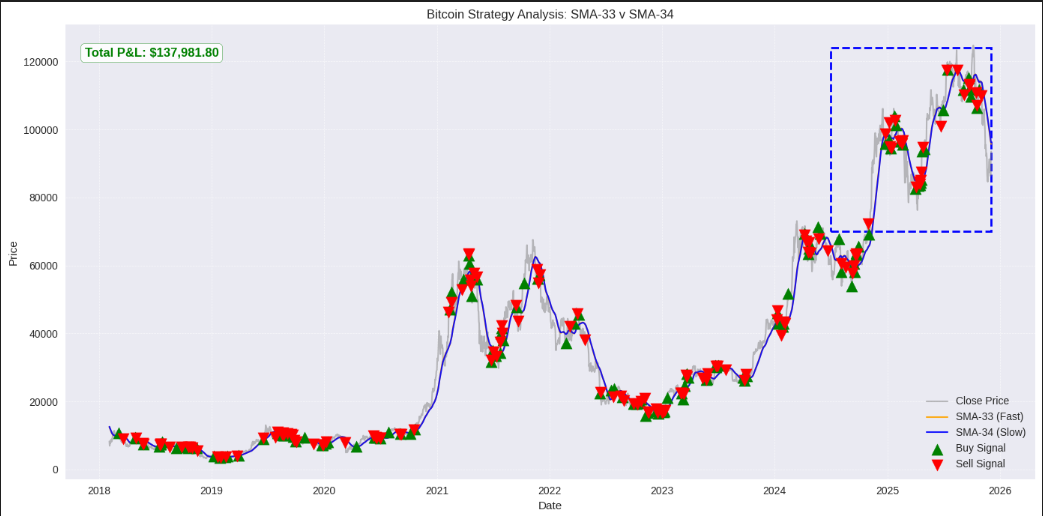

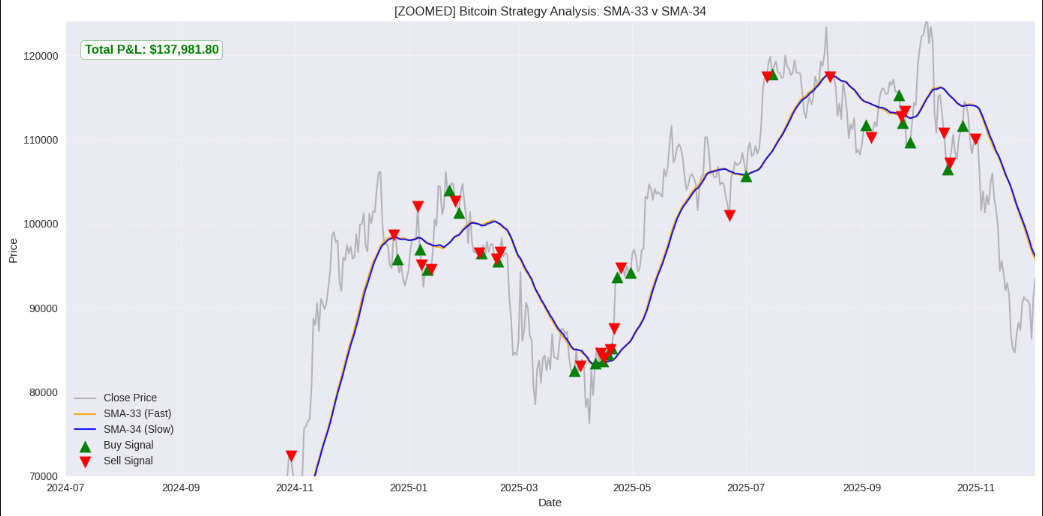

In [ ]:
window = [50, 200]
data = FeatureEngineeringStack(df)  ### FeatureEngineeringStack ###
signal, sma = StrategyTrendFollowing(data, window)
total_pnl = CalculateProfitLoss(data, signal)
print(data.shape, total_pnl)
plot = StrategyEval(data, signal, sma, total_pnl, box=True)
plot.show()

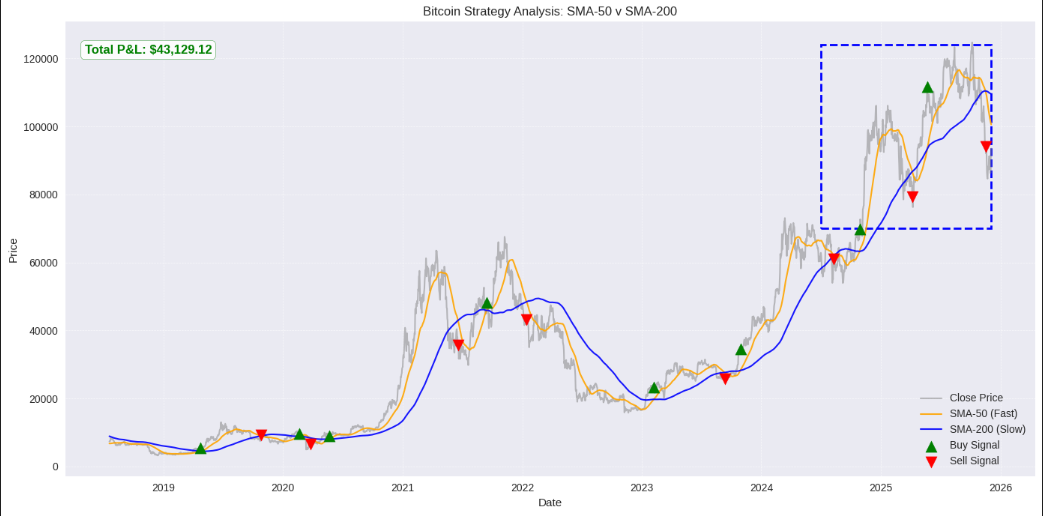

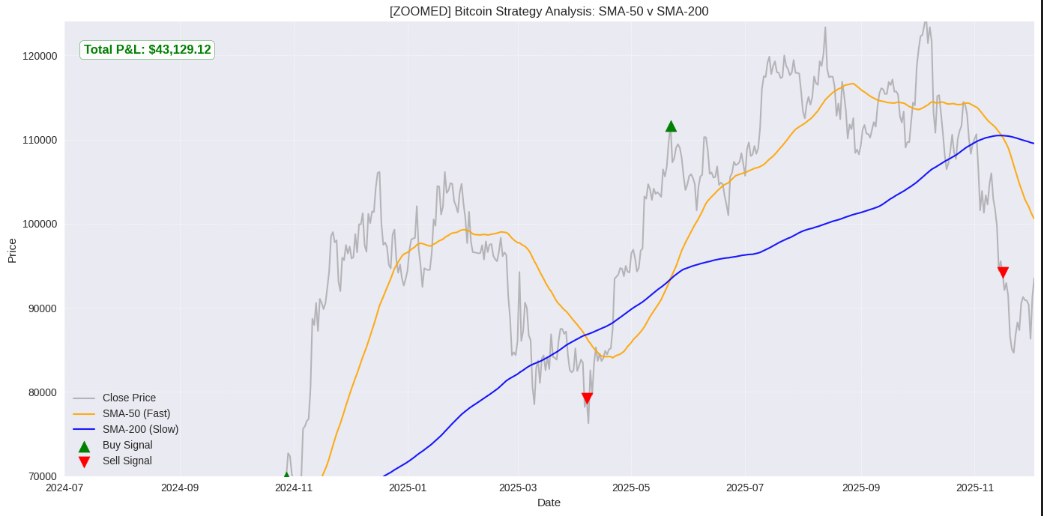